In [63]:
###################################
# Importing libraries and modules #
###################################

# Data Wrangling
import pandas as pd
import numpy as np
import collections
from scipy.stats import norm
import pandas_profiling

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import chart_studio.tools as tls
import chart_studio
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly_api_key import plotly_api_key

# Machine learning libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer #applies a power transformation to each feature to make the data more Gaussian-like.
from sklearn.model_selection import StratifiedKFold

# Library to balance targets
from imblearn.over_sampling import SMOTE
from collections import Counter

# import labelencoder
from sklearn.preprocessing import LabelEncoder
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
chart_studio.tools.set_credentials_file(username='rogerlefort', api_key=plotly_api_key)

In [4]:
###################################
#        Data Preprocessing       #
###################################

In [5]:
# Opening dataset
play_by_play = pd.read_csv('resources/final_table_for_model_build.csv')
play_by_play.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
3,56.0,1,1707.0,3507.0,4.0,8,3.0,3.0,0.0,punt,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0


In [6]:
play_by_play.play_type.value_counts()

pass          186363
run           132668
no_play        24134
punt           23937
field_goal      9790
qb_kneel        3757
qb_spike         690
Name: play_type, dtype: int64

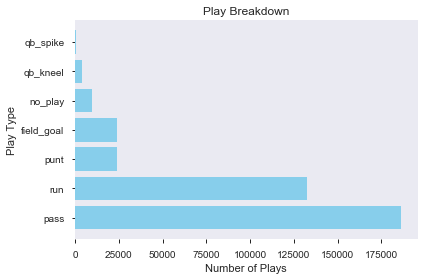

In [7]:
# Plotting play types
x_pos = play_by_play.play_type.unique()
y_values = play_by_play.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='SkyBlue')
plt.savefig('plots/play_breakdown_pre.png', dpi=600)
plt.tight_layout()
plt.show()

In [8]:
play_breakdown_before = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_before.update_layout(
    title_text="Play Breakdown - All Plays",
)
play_breakdown_before.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_before.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_before, filename = 'play_breakdown_before', auto_open=False)

'https://plot.ly/~rogerlefort/4/'

For our analysis, we'll only consider pass and run plays

In [9]:
only_productive_plays = play_by_play[(play_by_play.play_type == 'pass') | (play_by_play.play_type == 'run')]
# Removing duplicates
only_productive_plays.drop_duplicates().head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,play_type,desc,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,run,Sunny,73,0.0,17,6,32,0.0
5,98.0,1,1660.0,3460.0,2.0,10,3.0,3.0,0.0,pass,Sunny,73,0.0,17,6,32,0.0


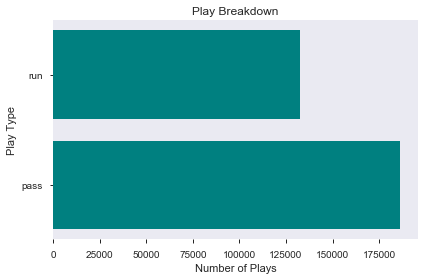

In [10]:
# Plotting play types with only passes and runs
x_pos = only_productive_plays.play_type.unique()
y_values = only_productive_plays.play_type.value_counts()
plt.ylabel('Play Type')
plt.xlabel('Number of Plays')
plt.title('Play Breakdown')
plt.grid(False)
plt.barh(x_pos, y_values, color='teal')
plt.tight_layout()
plt.savefig('plots/play_breakdown_post.png', dpi=600)
plt.show()

In [11]:
play_breakdown_after = go.Figure(data=[go.Pie(labels=x_pos, values=y_values, hole=.5)])

play_breakdown_after.update_layout(
    title_text="Play Breakdown - Runs and Passes",
)
play_breakdown_after.update_layout(
    legend=go.layout.Legend(
        x=-1,
        y=1,
        traceorder="normal",
        font=dict(
            family="Avenir",
            size=18,
            color="black"
        ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
    )
)
play_breakdown_after.show(renderer="iframe", width=500, height=500)
py.plot(play_breakdown_after, filename = 'play_breakdown_after', auto_open=False)

'https://plot.ly/~rogerlefort/59/'

In [12]:
# Selecting features
X = only_productive_plays.drop(columns=['play_type', 'desc'])
X.head()

,yardline_100,qtr,half_seconds_remaining,game_seconds_remaining,down,ydstogo,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,temperature,snow,windspeed,visibility,humidity,precipitation
0,58.0,1,1793.0,3593.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0
1,53.0,1,1756.0,3556.0,2.0,5,3.0,3.0,0.0,73,0.0,17,6,32,0.0
2,56.0,1,1715.0,3515.0,3.0,8,3.0,3.0,0.0,73,0.0,17,6,32,0.0
4,98.0,1,1696.0,3496.0,1.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0
5,98.0,1,1660.0,3460.0,2.0,10,3.0,3.0,0.0,73,0.0,17,6,32,0.0


In [13]:
# Selecting target
y = only_productive_plays.play_type
y.head()

0    pass
1     run
2    pass
4     run
5    pass
Name: play_type, dtype: object

In [14]:
print(X.shape)
print(y.shape)

(319031, 15)
(319031,)


In [15]:
# Getting statistics on features

In [16]:
# With Pandas profiling we can get a complete profile of all the features
# dataframe_profile = only_productive_plays.profile_report()
# dataframe_profile.to_file(output_file="dataset.html")
# dataframe_profile

In [17]:
# Checking for highly correlated feature_names
# rejected_variables = dataframe_profile.get_rejected_variables(threshold=0.8)
# rejected_variables

In [18]:
########################################
#  FEATURE ENGINEERING AND SELECTION   #
########################################

In [19]:
# With Pandas profiling we can get a complete profile of all the features
# feature_profile = X.profile_report()
# feature_profile.to_file(output_file="feature_profile_preprocessing.html")
# feature_profile

In [20]:
# Checking for highly correlated feature_names
# rejected_variables = feature_profile.get_rejected_variables(threshold=0.8)
# rejected_variables

Our dataset does not contain any correlated features (Threshold=0.8)

In [21]:
# # find the quartiles and IQR for each category
# groups = df.groupby('group')
# q1 = groups.quantile(q=0.25)
# q2 = groups.quantile(q=0.5)
# q3 = groups.quantile(q=0.75)
# iqr = q3 - q1
# upper = q3 + 1.5*iqr
# lower = q1 - 1.5*iqr

# # find the outliers for each category
# def outliers(group):
#     cat = group.name
#     return group[(group.score > upper.loc[cat]['score']) | (group.score < lower.loc[cat]['score'])]['score']
# out = groups.apply(outliers).dropna()

# # prepare outlier data for plotting, we need coordinates for every outlier.
# if not out.empty:
#     outx = []
#     outy = []
#     for keys in out.index:
#         outx.append(keys[0])
#         outy.append(out.loc[keys[0]].loc[keys[1]])

# p = figure(tools="", background_fill_color="#efefef", x_range=cats, toolbar_location=None)

# # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
# qmin = groups.quantile(q=0.00)
# qmax = groups.quantile(q=1.00)
# upper.score = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'score']),upper.score)]
# lower.score = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'score']),lower.score)]

# # stems
# p.segment(cats, upper.score, cats, q3.score, line_color="black")
# p.segment(cats, lower.score, cats, q1.score, line_color="black")

# # boxes
# p.vbar(cats, 0.7, q2.score, q3.score, fill_color="#E08E79", line_color="black")
# p.vbar(cats, 0.7, q1.score, q2.score, fill_color="#3B8686", line_color="black")

# # whiskers (almost-0 height rects simpler than segments)
# p.rect(cats, lower.score, 0.2, 0.01, line_color="black")
# p.rect(cats, upper.score, 0.2, 0.01, line_color="black")

# # outliers
# if not out.empty:
#     p.circle(outx, outy, size=6, color="#F38630", fill_alpha=0.6)

# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = "white"
# p.grid.grid_line_width = 2
# p.xaxis.major_label_text_font_size="12pt"

# output_file("boxplot.html", title="boxplot.py example")

# show(p)

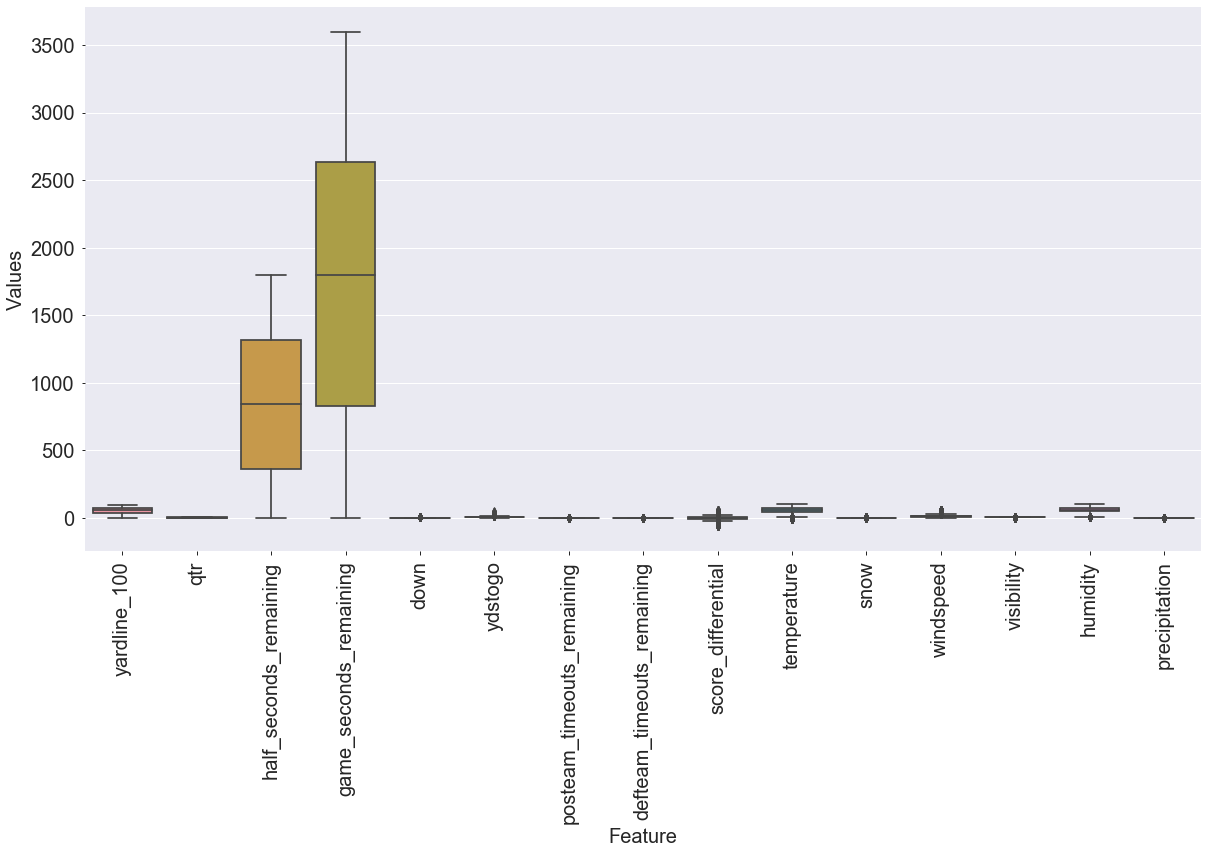

In [24]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X))
fig.set_size_inches(20, 10)
ax.set_ylabel('Values', fontsize=20)
ax.set_xlabel('Feature', fontsize=20)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical')
plt.show()

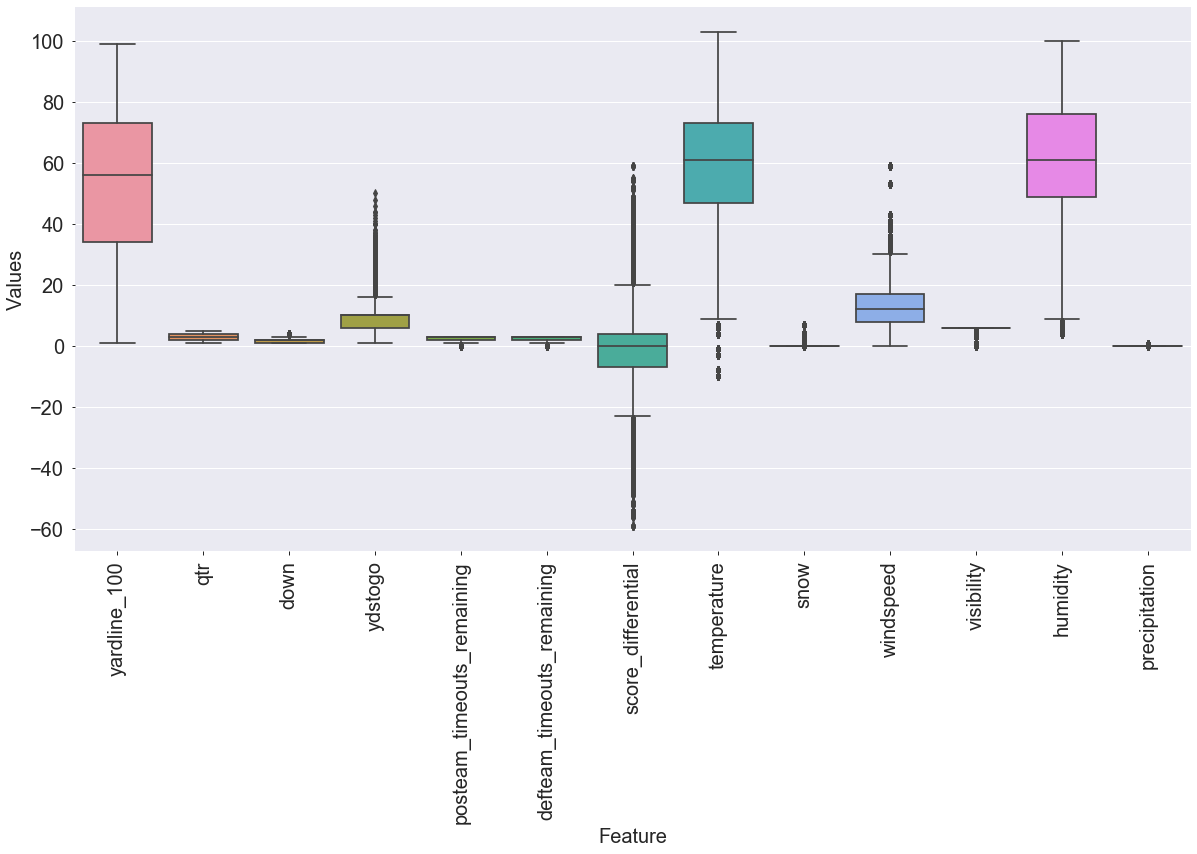

In [25]:
X_outliers = X.drop(columns=['half_seconds_remaining', 'game_seconds_remaining'])
fig, ax = plt.subplots()
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X_outliers))
fig.set_size_inches(20, 10)
ax.set_ylabel('Values', fontsize=20)
ax.set_xlabel('Feature', fontsize=20)
plt.tick_params(labelsize=20)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:


plot([go.Scatter(x=[1, 2, 3], y=[3, 1, 6])])

In [68]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

box_plot = go.Figure()
columns = X.columns
for col in columns:

    y = X[col]
    box_plot.add_trace(go.Box(y=y, name=col))


box_plot.show(renderer="iframe", width=800, height=500)
# py.plot(box_plot, filename = 'box_plot', auto_open=True)

A number of features contain outliers. All features will be transformed to account for outliers using power_transform

In [ ]:
####################################
#          Balancing dataset       #
####################################

In [ ]:
# applying SMOTE to our data and checking the class counts
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(X_resampled.shape)
print(y_resampled.shape)


# pt = PowerTransformer()
# pt.fit(X_resampled)
# X_resampled_transformed = pt.transform(X_resampled)
# print(sorted(Counter(y_resampled).items()))

# X_resampled_transformed.shape
# y_resampled.shape



In [ ]:
collections.Counter(y_resampled)

In [ ]:
print(X_resampled.shape)
print(y_resampled.shape)

In [ ]:
################################
# SELECTING IMPORTANT FEATURES #
################################

In [ ]:
rfc = RandomForestClassifier(random_state=100)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X_resampled, y_resampled)

print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.savefig('plots/RFECV_resampled.png', dpi=600)
plt.show()


In [ ]:
print(np.where(rfecv.support_ == False)[0])

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=20, pad=20)
plt.xlabel('Number of features selected', fontsize=16, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=2)
plt.tight_layout()
plt.savefig('plots/RFECV.png', dpi=600)
plt.show()

In [ ]:
rfecv_plot = go.Figure(go.Scatter(
    x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    y=rfecv.grid_scores_
))

rfecv_plot.update_layout(
    title_text="Recursive Feature Elimination with Cross-Validation",
    xaxis_title="Number of Features Selected",
    yaxis_title="% Correct Classification",
)

# rfecv_plot.update_layout(
#     legend=go.layout.Legend(
#         x=0,
#         y=1,
#         traceorder="normal",
#         font=dict(
#             family="Avenir",
#             size=18,
#             color="black"
#         ),
#         bgcolor="LightSteelBlue",
#         bordercolor="Black",
#         borderwidth=2
#     )
# )
# fig.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_plot, filename = 'rfecv_plot', auto_open=False)

In [ ]:
non_impotant_features = np.where(rfecv.support_ == False)[0]
print(non_impotant_features)

In [ ]:
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_


In [ ]:
dset = dset.sort_values(by='importance', ascending=False)
dset.head(8)

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
ax.tick_params(labelsize=14)
plt.title('RFECV - Feature Importances', fontsize=20, pad=20)
plt.xlabel('Importance', fontsize=16, labelpad=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.savefig('plots/important_features.png', dpi=600)
plt.show()

In [ ]:
# fig = go.Figure()

rfecv_features = go.Figure(data=go.Bar(
            x=dset['importance'],
            y=dset['attr'],
            marker=dict(
                color='rgba(8,80,111,100)'),
            orientation='h')
               )

rfecv_features.update_layout(
    title_text="RFECV - Feature Importances",
    xaxis_title="Importance Score",
)

rfecv_features.show(renderer="iframe", width=1200, height=800)
py.plot(rfecv_features, filename = 'rfecv_features', auto_open=False)

In [ ]:
#################################################################
# Saving selected dataset after removing non-important features
X_selected = X.copy()
X_selected.to_csv('X_selected.csv', index=False)
#################################################################
# Saving selected targets to match naming structure
y_selected = y.copy()
y_selected.to_csv('y_selected.csv', header=True, index=False)

In [ ]:
# Visualizing feature importance on final dataset
from yellowbrick.features import ParallelCoordinates
from yellowbrick.datasets import load_occupancy

# Load the classification data set
X_resampled, y_resampled = load_occupancy()

# Specify the features of interest and the classes of the target
features = ['yard_line', 'half_sec', 'game_sec', 'humidity', 'down', 'temp', 'score_diff', 'ydstogo']
classes = ['pass', 'run']

# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features,
    normalize='standard', sample=0.05, shuffle=True,
)

# Fit the visualizer and display it
visualizer.fit_transform(X_selected, y_selected)
visualizer.show(outpath='plots/ParallelCoordinates.png', dpi=600)

#### SUMMARY

1. Target classes were balanced for equal sampling of pass and run
2. Feature set was reduced from 15 to 8 using RFECV method on balanced data
3. Renamed new feature and target datasets as X_selected and y_selected 

*Note: X_selected and y_selected are not balanced*

In [ ]:
# X.dtypes

In [ ]:
# # Converting some down and qtr features to categorical
# X.down = X.down.astype(str)
# X.qtr = X.qtr.astype(str)

In [ ]:
# X.dtypes

In [ ]:
# # Encoding categorical features
# # Categorical boolean mask
# categorical_feature_mask = X.dtypes==object
# # filter categorical columns using mask and turn it into a list
# categorical_cols = X.columns[categorical_feature_mask].tolist()
# categorical_cols

In [ ]:
# # Instantiate labelencoder object
# le = LabelEncoder()
# # Apply le on categorical feature columns
# X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
# X[categorical_cols].head(10)

In [ ]:
# # Instantiate OneHotEncoder
# ohe = OneHotEncoder(categorical_features = categorical_feature_mask, sparse=False ) 
# # categorical_features = boolean mask for categorical columns
# # sparse = False output an array not sparse matrix

In [ ]:
# # apply OneHotEncoder on categorical feature columns
# X_ohe = ohe.fit_transform(X) # It returns an numpy array

In [ ]:
# X_ohe

In [ ]:
# rfc = RandomForestClassifier(random_state=100)
# rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
# rfecv.fit(X_ohe, y)

# print('Optimal number of features: {}'.format(rfecv.n_features_))

# plt.figure(figsize=(16, 9))
# plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
# plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
# plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
# plt.savefig('plots/RFECV.png', dpi=600)
# plt.show()

In [ ]:
# print(np.where(rfecv.support_ == False)[0])

In [ ]:
# rfecv.estimator_.feature_importances_

In [ ]:
# X.columns

In [ ]:
# dset = pd.DataFrame()
# dset['attr'] = X_ohe.columns
# dset['importance'] = rfecv.estimator_.feature_importances_

# # dset = dset.sort_values(by='importance', ascending=False)
# # dset.head()

In [ ]:
# plt.figure(figsize=(16, 14))
# plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
# plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
# plt.xlabel('Importance', fontsize=14, labelpad=20)
# plt.savefig('plots/important_features.png', dpi=600)
# plt.show()

In [ ]:
# transformed = np.cbrt(play_by_play.precipitation)

In [ ]:
# transformed